# Financial Fraud Detection with Neo4j and Graph Data Science

This notebook demonstrates the power of Graph Databases and Graph Data Science (GDS) in financial fraud applications, in a transactional setting. Unlike traditional tabular analysis, graph analysis allows us to uncover complex patterns, such as fraud rings, mule accounts, and shared device usage, by treating data as a connected network.

In this notebook we give examples of typical fraud detection tasks, using the [**IEEE CIS Fraud Detection** dataset](https://www.kaggle.com/c/ieee-fraud-detection) stored in a **Neo4j** database, which we populated previously in [`loader.ipynb`](loader.ipynb).

**Key Analysis Steps:**
1.  **Exploratory Data Analysis (EDA)**: Understanding the graph schema and size.
2.  **Pattern Matching**: Identifying suspicious connectivity (e.g., devices shared by multiple cards).
3.  **Path Analysis**: Tracing connections between known fraud entities and potential high-value targets (money mules).
4.  **Graph Data Science**: Using the **Louvain** algorithm to detect communities and analyzing them for high fraud density ("Fraud Islands").
5.  **Temporal Analysis**: Visualizing the velocity of fraud within these communities over time.

We first need a few helper methods to run Cypher queries and visualize results. Make sure you have set up your environment by running:

```bash
conda env update
```

In [ ]:
from dotenv import load_dotenv
import os
from neo4j import GraphDatabase, Result
from playwright.async_api import async_playwright
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import squarify
import seaborn as sns

load_dotenv()

class Neo4jAnalysis:
    def __init__(self, uri, user, password, database):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.database = database

    def close(self):
        self.driver.close()

    def run_query(self, query, params=None):
        with self.driver.session(database=self.database) as session:
            result = session.run(query, params or {})
            return result.data() 

    def run_query_viz(self, query, params=None):
        result = self.driver.execute_query(
            query,
            parameters_=params or {},
            database_=self.database,
            result_transformer_=Result.graph,
        )
        return result

    async def capture_graph_to_png(self, html_content, output_path):
        # Save content to a temporary HTML file
        with open("remove.html", "w", encoding="utf-8") as f:
            f.write(html_content.data)
        async with async_playwright() as p:
            # Launch a headless browser
            browser = await p.chromium.launch()
            page = await browser.new_page()
            
            # Load the local HTML file
            abs_path = f"file://{os.path.abspath('remove.html')}"
            await page.goto(abs_path)
            
            # Wait for the force-directed layout to stabilize
            await page.wait_for_timeout(8000) 
            
            # Take the screenshot
            await page.screenshot(path=output_path, full_page=True)
            await browser.close()
        # Clean up the temporary file
        os.remove("remove.html")

    def plot_community_treemap(self, query):
        with self.driver.session(database=self.database) as session:
            result = session.run(query)
            df = pd.DataFrame([dict(record) for record in result])
        
        if df.empty:
            print("No data found for the treemap.")
            return

        # Prepare Data
        df['fraud_density'] = (df['fraud_count'] / df['transaction_count']) * 100
        df = df.sort_values(by='total_value', ascending=False).head(200) 
        
        # Setup Colors and Normalization
        cmap = mpl.cm.RdBu_r
        norm = mpl.colors.Normalize(vmin=0, vmax=20) 
        colors = [cmap(norm(value)) for value in df['fraud_density']]

        # Create the Plot
        fig, ax = plt.subplots(figsize=(16, 10)) 
        
        all_labels = [
            f"ID: {row.community}\n${row.total_value:,.0f}" if i < 10 else "" 
            for i, row in enumerate(df.itertuples())
        ]

        squarify.plot(sizes=df['total_value'], 
                      label=all_labels, 
                      color=colors, 
                      alpha=0.8, 
                      edgecolor="white", 
                      linewidth=1,
                      ax=ax) 

        # Add Colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, label='Fraud Density (%)', pad=0.02)

        plt.title('Fraud Communities: Size = Total Value, Color = Fraud Density %', fontsize=15)
        plt.axis('off') 
        plt.show()

NEO4J_URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_TRAIN_DATABASE = os.getenv("NEO4J_TRAIN_DATABASE")
AUTH = (NEO4J_USER, NEO4J_PASSWORD)

analysis = Neo4jAnalysis(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD, NEO4J_TRAIN_DATABASE)

## Setup and Dependencies

We install `playwright` to enable high-quality graph visualization rendering directly in the notebook, together with [neo4j-viz](https://github.com/neo4j/python-graph-visualization).

In [2]:
# Install playwright browsers if not already installed
!playwright install chromium

## Exploratory Data Analysis (EDA)

First, we connect to the Neo4j database and examine the distribution of Nodes and Relationships. This gives us a sense of the graph's scale and topology. The dataset only contains email domains rather than full email addresses, and physical addresses are restricted to region codes and countries.

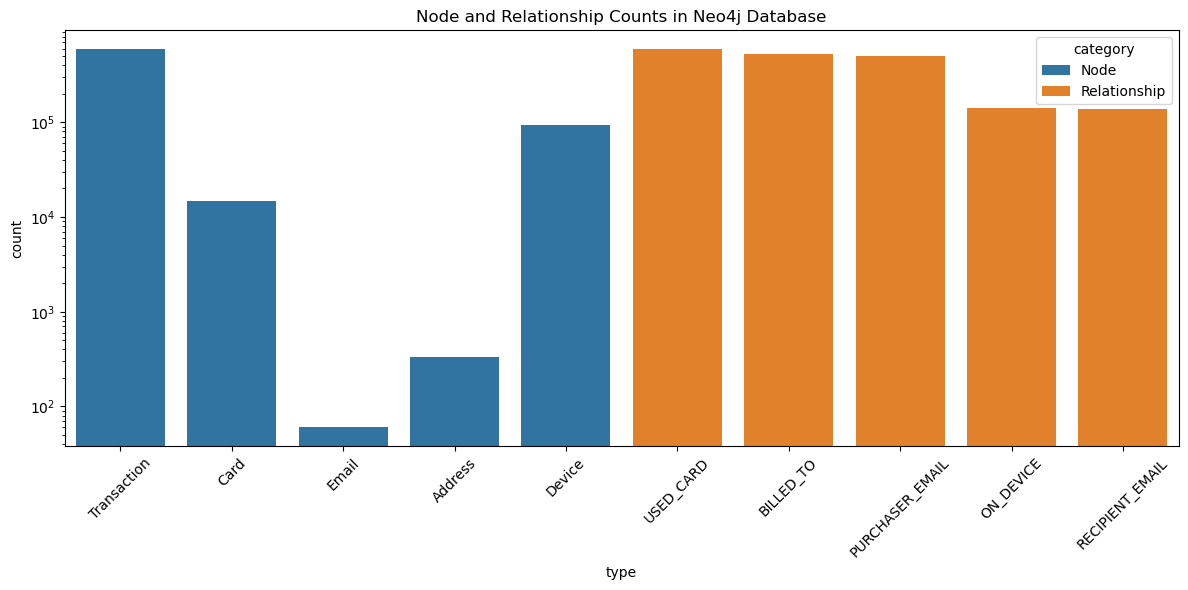

In [3]:
query = """
MATCH (n)
UNWIND labels(n) AS type
RETURN "Node" AS category, type, count(*) AS count
UNION ALL
MATCH ()-[r]->()
RETURN "Relationship" AS category, type(r) AS type, count(*) AS count
ORDER BY category, count DESC;
"""

results = analysis.run_query(query)

# Visualise with Seaborn
df = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="type", y="count", hue="category")
plt.xticks(rotation=45)
plt.yscale("log")
plt.title("Node and Relationship Counts in Neo4j Database")
plt.tight_layout()
plt.show()

### Graph Schema Visualization

Understanding the data model is crucial. Let's visualize the schema to see how `Transactions`, `Cards`, `Devices`, and other entities are related.

In [4]:
from neo4j_viz.neo4j import from_neo4j, ColorSpace

# Plot schema visualization
schema = """
CALL apoc.meta.graph()
"""

schema_result = analysis.run_query_viz(schema)
VG = from_neo4j(schema_result)
VG.color_nodes(
    field="caption", # Using the internal labels property
    color_space=ColorSpace.DISCRETE,
    colors={
        "Card": "#1f77b4",        # Blue for Cards
        "Device": "#ff7f0e",      # Orange for Devices
        "Transaction": "#d62728",   # Red for the link (if fraud)
        "Address": "#ff00ff",      # Magenta for Addresses,
        "Email": "#a020f0"        # Purple for Emails
    },
)
generated_html = VG.render(layout="forcedirected", initial_zoom=1.5)

In [5]:
await analysis.capture_graph_to_png(generated_html, "renderings/schema_graph.png")

![Graph Schema](renderings/schema_graph.png)

## Device Fingerprinting Analysis

Fraudsters often re-use devices. By analyzing `Device` nodes, we can develop an intuition of the distribution of individual devices used in transactions.

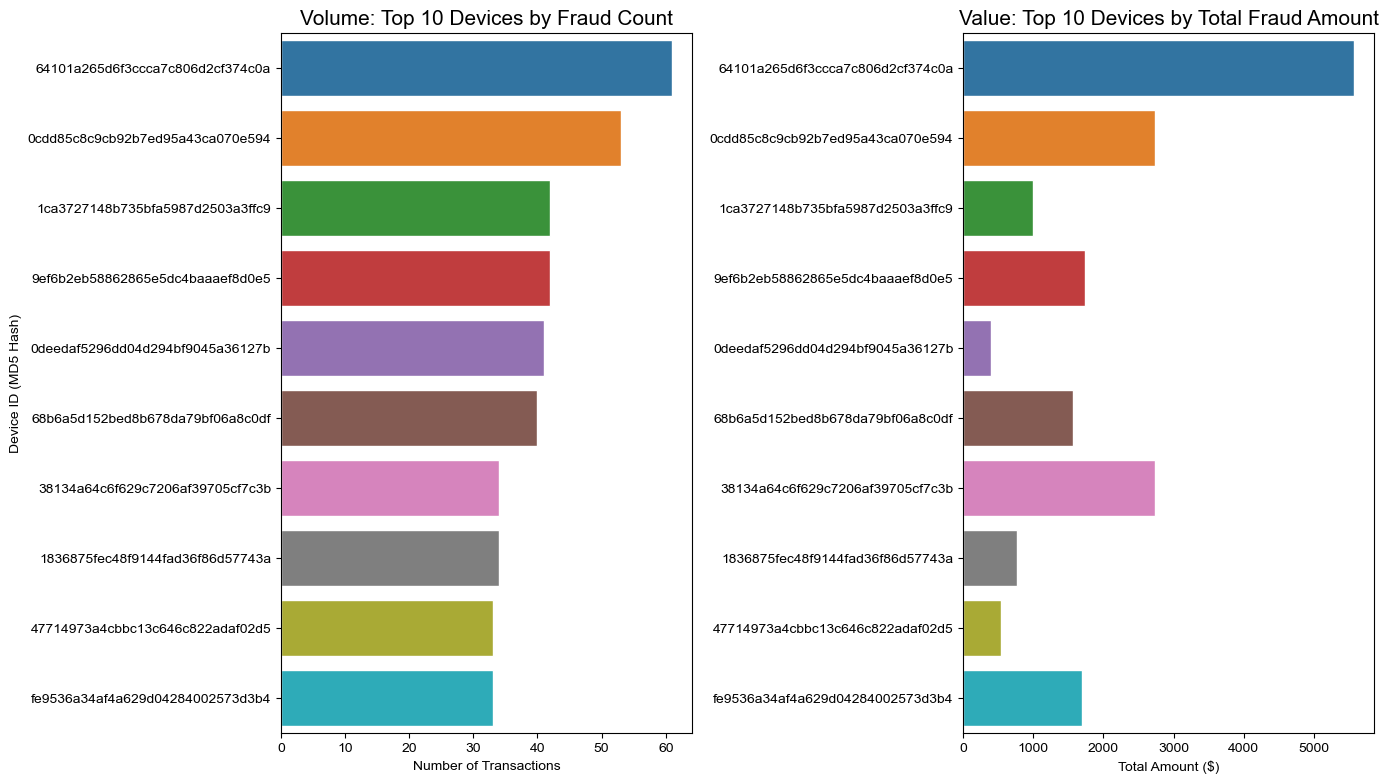

In [6]:
import hashlib

# Top 10 Fraudulent Devices
query = """
MATCH (d:Device)<-[:ON_DEVICE]-(t:Transaction)
WHERE t.isFraud = 1
RETURN 
    d.id AS Fingerprint,
    d.browser AS Browser,
    d.os AS OS,
    count(t) AS FraudulentTransactions,
    sum(t.amt) AS TotalFraudAmount
ORDER BY FraudulentTransactions DESC
LIMIT 10;
"""

results = analysis.run_query(query)
df = pd.DataFrame(results)

# Define a function to generate an MD5 hash
def generate_md5(text):
    return hashlib.md5(str(text).encode('utf-8')).hexdigest()

# Apply the hash to the Fingerprint
df['Hashed_Fingerprint'] = df['Fingerprint'].apply(generate_md5)

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Plot 1: Count of Fraudulent Transactions
sns.barplot(
    data=df, 
    x='FraudulentTransactions', 
    y='Hashed_Fingerprint', 
    hue='Hashed_Fingerprint',
    ax=axes[0], 
    palette='tab10',
    legend=False
)
axes[0].set_title('Volume: Top 10 Devices by Fraud Count', fontsize=15)
axes[0].set_xlabel('Number of Transactions')
axes[0].set_ylabel('Device ID (MD5 Hash)')

# Plot 2: Total Fraud Amount
sns.barplot(
    data=df, 
    x='TotalFraudAmount', 
    y='Hashed_Fingerprint', 
    hue='Hashed_Fingerprint',
    ax=axes[1], 
    palette='tab10',
    legend=False
)
axes[1].set_title('Value: Top 10 Devices by Total Fraud Amount', fontsize=15)
axes[1].set_xlabel('Total Amount ($)')
axes[1].set_ylabel('') 

plt.tight_layout()
plt.show()

We can also visualize the distribution of fraudulent transactions per device, which tells us that most devices are associated with very few fraudulent transactions, while a small number of devices are linked to many fraudulent activities.

This is generally expected in fraud scenarios, where a few compromised devices are used extensively for fraudulent purposes.

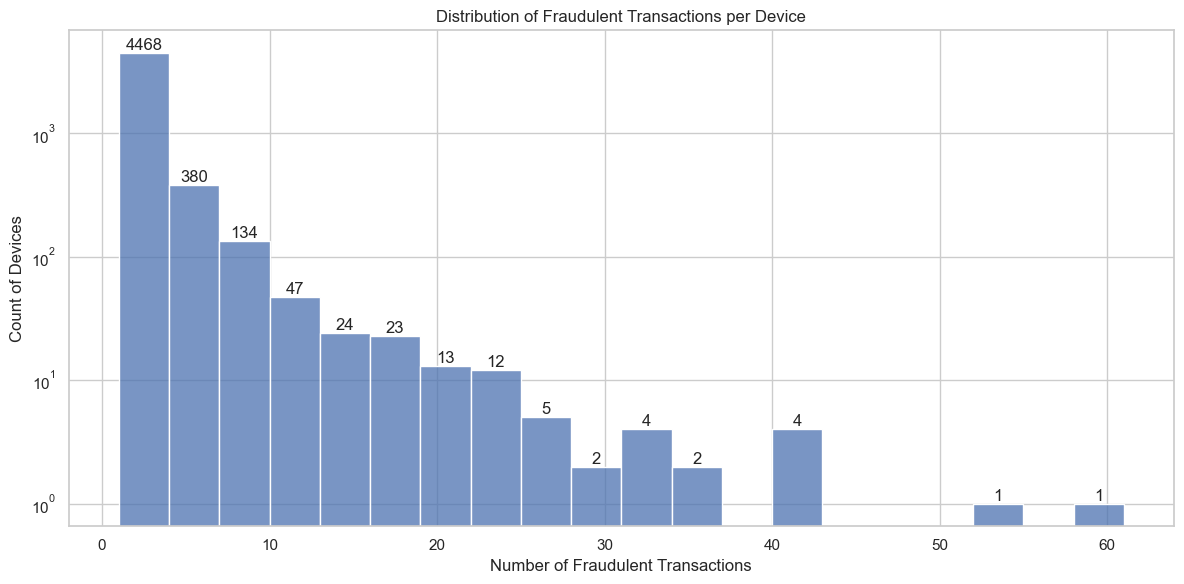

In [7]:
# Plot an histogram of device vs number of fraudulent transactions
query = """
MATCH (d:Device)<-[:ON_DEVICE]-(t:Transaction)
WHERE t.isFraud = 1
RETURN 
    d.id AS DeviceID,
    count(t) AS FraudulentTransactionCount
ORDER BY FraudulentTransactionCount DESC;
"""

results = analysis.run_query(query)
df = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['FraudulentTransactionCount'], bins=20, kde=False)
plt.title('Distribution of Fraudulent Transactions per Device')
plt.yscale("log")
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Count of Devices')

for container in ax.containers:
    ax.bar_label(container)  # Add labels to each bar
    
plt.tight_layout()
plt.show()

### High-Risk Multi-Card Devices

A strong indicator of fraud is a single device being used by multiple unique credit cards. This often signals a "device farm" or a compromised terminal. We calculate the hashing to group these fingerprints. Using Cypher, we can easily identify devices associated with multiple cards and visualize the top offenders. This can help prioritize investigations into potentially fraudulent activity.

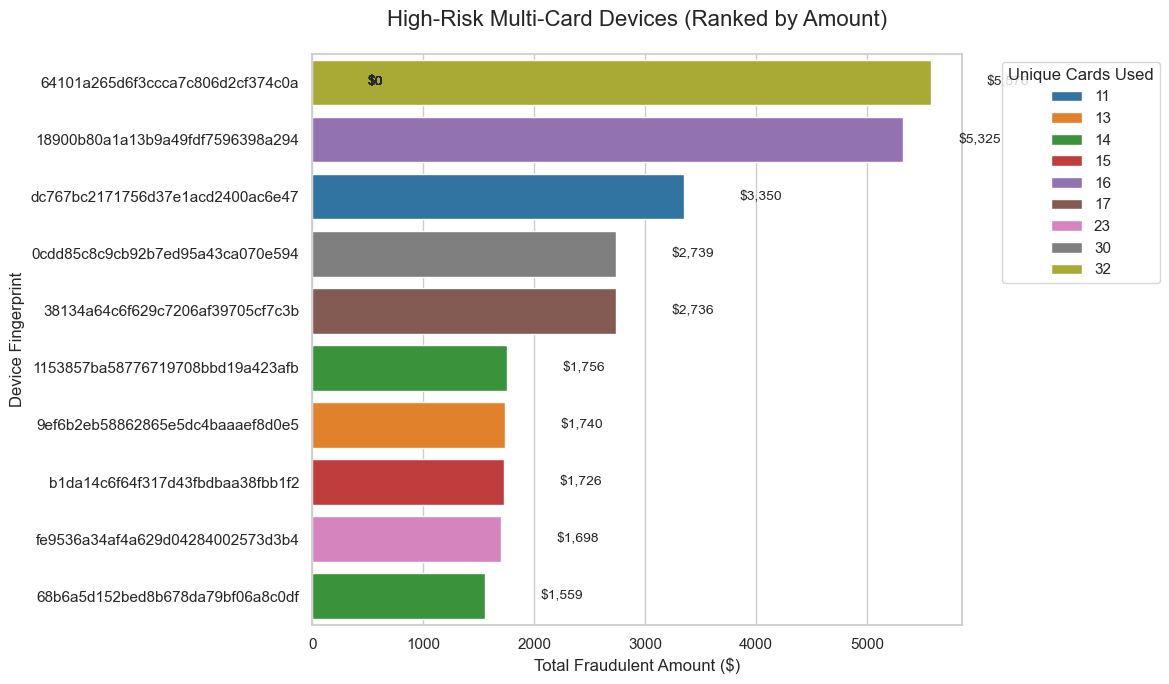

In [8]:
# High-Risk Multi Card Devices
query = """
MATCH (c:Card)<-[:USED_CARD]-(t:Transaction)-[:ON_DEVICE]->(d:Device)
WHERE t.isFraud = 1
WITH d, 
     count(DISTINCT c.id) AS UniqueCardsUsed, 
     count(t) AS TotalFraudTransactions,
     sum(t.amt) AS TotalAmount
WHERE UniqueCardsUsed >= 10
RETURN 
    d.id AS Fingerprint,
    UniqueCardsUsed,
    TotalFraudTransactions,
    TotalAmount
ORDER BY TotalAmount DESC
LIMIT 10;
"""

results = analysis.run_query(query)

df = pd.DataFrame(results)

# Apply the hash to the Fingerprint
df['Hashed_Fingerprint'] = df['Fingerprint'].apply(generate_md5)

plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# We use 'TotalAmount' for the bar length and 'UniqueCardsUsed' for the color intensity
plot = sns.barplot(
    data=df,
    x='TotalAmount',
    y='Hashed_Fingerprint',
    hue='UniqueCardsUsed',
    dodge=False,
    palette='tab10'
)

plt.title('High-Risk Multi-Card Devices (Ranked by Amount)', fontsize=16, pad=20)
plt.xlabel('Total Fraudulent Amount ($)', fontsize=12)
plt.ylabel('Device Fingerprint', fontsize=12)
plt.legend(title='Unique Cards Used', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in plot.patches:
    width = p.get_width()
    plt.text(width + 500, p.get_y() + p.get_height()/2, 
             f'${width:,.0f}', 
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Fraud Ring Detection

A typical scenario in fraud detection is identifying "fraud rings": groups of entities (cards, devices, accounts) that are interconnected through suspicious transactions. These rings often indicate coordinated fraudulent activity. We can search for "rings" by inspecting closed loops or concentrated patterns where multiple transactions and cards link back to the same device.

The following query finds devices connected to multiple cards involved in fraudulent transactions, highlighting a potential fraud ring centered on a single device with the highest card diversity.

In [9]:
from neo4j_viz.neo4j import ColorSpace

ring_query = """
// Find the single device with the highest card diversity and at least one fraud
MATCH (c:Card)<-[:USED_CARD]-(t:Transaction)-[:ON_DEVICE]->(d:Device)
WITH d, count(DISTINCT c) AS card_count, collect(t) AS trans
WHERE card_count > 10 AND any(x IN trans WHERE x.isFraud = 1)
ORDER BY card_count DESC
LIMIT 1 // Force the query to focus on ONE interconnected cluster

// Fetch all fraudulent transactions and associated cards for THIS specific device
MATCH p = (c2:Card)<-[:USED_CARD]-(t2:Transaction)-[:ON_DEVICE]->(d)
WHERE t2.isFraud = 1
RETURN p
"""

fraud_ring_result = analysis.run_query_viz(ring_query)
print(f"Nodes: {len(fraud_ring_result.nodes)}, Edges: {len(fraud_ring_result.relationships)}")

VG = from_neo4j(fraud_ring_result)
VG.resize_nodes(property="amt", node_radius_min_max=(10, 30))
VG.color_nodes(
    field="caption", # Using the internal labels property
    color_space=ColorSpace.DISCRETE,
    colors={
        "Card": "#1f77b4",        # Blue for Cards
        "Device": "#ff7f0e",      # Orange for Devices
        "Transaction": "#d62728",   # Red for the link (if fraud)
        "Address": "#ff00ff",      # Magenta for Addresses,
        "Email": "#a020f0"        # Purple for Emails
    },
)
VG.color_nodes(
    property="isFraud",
    color_space=ColorSpace.DISCRETE,
    colors={0: "green", 1: "red"},
)
generated_html = VG.render(layout="forcedirected", initial_zoom=0.8, height="800px")

Nodes: 38, Edges: 42


In [10]:
await analysis.capture_graph_to_png(generated_html, "renderings/ring_query_graph.png")

![Ring Fraud Graph](renderings/ring_query_graph.png)

Now let us present the ring as a table of cards and associated fraudulent transaction counts.

In [11]:
import pandas as pd

# Cypher query to count fraudulent transactions per card
hot_cards_query = """
MATCH (c:Card)<-[:USED_CARD]-(t:Transaction)
WHERE t.isFraud = 1
RETURN 
    c.id AS CardID, 
    count(t) AS FraudCount, 
    sum(t.amt) AS TotalFraudAmount
ORDER BY FraudCount DESC
LIMIT 20
"""

# Execute and convert to DataFrame
results = analysis.run_query(hot_cards_query)
df_hot_cards = pd.DataFrame(results)

# Display the top cards
print("Top 20 Cards by Fraudulent Transaction Count:")
df_hot_cards

Top 20 Cards by Fraudulent Transaction Count:


,CardID,FraudCount,TotalFraudAmount
0,9500-321.0-150.0-visa-226.0-debit,527,106652.206
1,9633-130.0-185.0-visa-138.0-debit,465,19868.391
2,15885-545.0-185.0-visa-138.0-debit,442,20986.753
3,9026-545.0-185.0-visa-137.0-credit,396,20634.539
4,5812-408.0-185.0-mastercard-224.0-debit,314,14565.038
5,15066-170.0-150.0-mastercard-102.0-credit,313,51263.863
6,9917-142.0-185.0-visa-138.0-debit,305,13981.515
7,6019-583.0-150.0-visa-226.0-credit,294,83859.028
8,3154-408.0-185.0-mastercard-224.0-debit,286,11169.304
9,17188-321.0-150.0-visa-226.0-debit,278,44641.667


### Multiple-Hop Fraud Rings

Fraud is often layered and interconnected. We can extend our search to 5 hops (e.g., `Transactions` -> `Cards` -> `Devices` -> `Cards` -> `Transactions`) to find complex networks linking `Transactions`, `Cards`, and `Devices`. We start from a known fraudulent transaction and explore the network around it to identify potential fraud rings.

In [12]:
# This query explores deep connections (up to 5 hops) between fraudulent entities.
# It starts with a confirmed fraudulent transaction and traverses the network via cards and devices.
# To keep the focus strictly on fraud, it ensures that any transaction node found in the path 
# must have its isFraud property set to 1.
# This reveals the infrastructure of a fraud ring, showing how separate fraud events are 
# linked by shared hardware or accounts.

deep_fraud_ring_query = """
MATCH (start:Transaction {isFraud: 1})

// Expand up to 5 hops through cards and devices
MATCH p = (start)-[:USED_CARD|ON_DEVICE*1..5]-(entity)

// Constraint: If the path touches a Transaction, it MUST be fraud.
// We also keep the visualization focused on Cards and Devices.
WHERE all(n IN nodes(p) WHERE NOT n:Transaction OR n.isFraud = 1)
  AND (entity:Card OR entity:Device OR entity:Transaction)

RETURN p
LIMIT 75
"""

deep_ring_result = analysis.run_query_viz(deep_fraud_ring_query)
print(f"Nodes: {len(deep_ring_result.nodes)}, Edges: {len(deep_ring_result.relationships)}")

VG = from_neo4j(deep_ring_result)

# Size by amount for transactions
VG.resize_nodes(property="amt", node_radius_min_max=(10, 30))

VG.color_nodes(
    field="caption", # Using the internal labels property
    color_space=ColorSpace.DISCRETE,
    colors={
        "Card": "#1f77b4",        # Blue for Cards
        "Device": "#ff7f0e",      # Orange for Devices
        "Transaction": "#d62728",   # Red for the link (if fraud)
        "Address": "#ff00ff",      # Magenta for Addresses,
        "Email": "#a020f0"        # Purple for Emails
    },
)
VG.color_nodes(
    property="isFraud",
    color_space=ColorSpace.DISCRETE,
    colors={1: "red", 0: "green"}, 
)

generated_html = VG.render(layout="forcedirected", initial_zoom=0.75, height="800px")

Nodes: 69, Edges: 71


In [13]:
await analysis.capture_graph_to_png(generated_html, "renderings/deep_fraud_ring_graph.png")

![Deep Fraud Ring Graph](renderings/deep_fraud_ring_graph.png)

## Path Analysis: Connecting Fraudsters

Do distinct fraud devices share a connection? We use Shortest Path algorithms to see if two separate fraudulent devices are linked by a common card or intermediary. This can reveal hidden relationships between fraudsters, and potentially uncover larger fraud rings.

In the geometry of financial crime, these paths often reveal the **"connective tissue"** of a professional operation. While an amateur fraudster might appear as a simple 'Star' topology (one device, one card), Shortest Path analysis frequently uncovers complex **'Chain' or 'Mule' geometries**. These paths demonstrate how stolen funds are funneled through a sequence of accounts to obscure their origin and bypass bank velocity triggers.

Finding a path between seemingly unrelated devices helps identify **'Bridge Nodes'**. These are often the single points of failure in a fraud ring, such as a specific VPN provider, a compromised merchant terminal, or a shared 'burner' phone number. By focusing on these intersections rather than isolated nodes, investigators can shift from reactive blocking of individual cards to proactive disruption of the entire infrastructure holding the 'Fraud Island' together. This approach effectively identifies not just the 'leaves' of the crime (the transactions) but the 'roots' (the masterminds and shared tools).

In [14]:
shortest_path_query = """
// Find two distinct devices involved in fraud
MATCH (d1:Device), (d2:Device)
WHERE d1 <> d2 
  AND EXISTS { MATCH (d1)<-[:ON_DEVICE]-(t1:Transaction) WHERE t1.isFraud = 1 }
  AND EXISTS { MATCH (d2)<-[:ON_DEVICE]-(t2:Transaction) WHERE t2.isFraud = 1 }

// Calculate the shortest path between them 
// We restrict the path to only use Cards and Transactions
MATCH p = shortestPath((d1)-[:ON_DEVICE|USED_CARD*..15]-(d2))

// Ensure the path actually contains fraud transactions
WHERE all(t IN nodes(p) WHERE NOT t:Transaction OR t.isFraud = 1)

RETURN p
LIMIT 1
"""

shortest_path_result = analysis.run_query_viz(shortest_path_query)
print(f"Nodes: {len(shortest_path_result.nodes)}, Edges: {len(shortest_path_result.relationships)}")

VG = from_neo4j(shortest_path_result)
VG.resize_nodes(property="amt", node_radius_min_max=(10, 30))
VG.color_nodes(
    field="caption", # Using the internal labels property
    color_space=ColorSpace.DISCRETE,
    colors={
        "Card": "#1f77b4",        # Blue for Cards
        "Device": "#ff7f0e",      # Orange for Devices
        "Transaction": "#d62728",   # Red for the link (if fraud)
        "Address": "#ff00ff",      # Magenta for Addresses,
        "Email": "#a020f0"        # Purple for Emails
    },
)
VG.color_nodes(
    property="isFraud",
    color_space=ColorSpace.DISCRETE,
    colors={0: "green", 1: "red"},
)
generated_html = VG.render(layout="forcedirected", initial_zoom=1.2, height="800px")

Nodes: 9, Edges: 8


In [15]:
await analysis.capture_graph_to_png(generated_html, "renderings/shortest_path_graph.png")

![Shortest Path Fraud Graph](renderings/shortest_path_graph.png)

### Money Laundering Detection: The "High-Value Mule"

We look for paths connecting confirmed fraud to **'Clean Whales'**: high-value cards with no direct fraud history. These are potential exit nodes for money laundering.

In a graph, these relationships are rarely direct. Instead, they represent the **'Layering' stage of money laundering**, where fraudsters attempt to distance 'dirty' funds from their criminal origin through a series of complex, intermediary transactions. By using path-finding algorithms like **All Pairs Shortest Path** or **Breadth-First Search (BFS)**, we can measure the 'degrees of separation' between a known fraud island and a high-limit legitimate account.

If a 'Clean Whale' is only two or three hops away from a cluster of confirmed fraud - linked perhaps by a shared IP address used months apart or a common merchant - it is no longer considered 'clean.' It becomes a **High-Risk Mule Candidate**. Identifying these paths allows investigators to move beyond detecting past theft and begin predicting the **'Integration' stage**, where the illicit funds are finally withdrawn or spent. Mapping these 'exit ramps' is critical for Anti-Money Laundering (AML) compliance, as it enables the bank to freeze the pipeline before the funds are successfully laundered into the legitimate economy.

**Note:** In the below visualisation, we highlight the path from known fraudulent cards (red) to a high-value card with no prior fraud history (green).

In [16]:
# The "High-Value Mule" Shortest Path
#
# This query finds the shortest path between a known fraud transaction and a clean card that has processed a
# high total volume of money (summed from its transactions). These "clean" cards are often the exit points
# for a fraud ring.

# What this shows: A direct line from a "dirty" event to a "whale" account that appears legitimate.
# If a path exists, that "clean" card is likely a money-laundering node.

whale_query = """
// Identify "Clean Whales" (High spend, zero fraud)
MATCH (clean:Card)<-[:USED_CARD]-(t:Transaction)
WITH clean, sum(t.amt) AS total_spend
WHERE total_spend > 1000 
  AND all(tx IN [(clean)<-[:USED_CARD]-(tx) | tx] WHERE tx.isFraud = 0)
WITH clean ORDER BY total_spend DESC LIMIT 1

// Identify "Fraud Cards" (At least 5 fraudulent transactions)
MATCH (fraudCard:Card)<-[:USED_CARD]-(t2:Transaction)
WHERE t2.isFraud = 1
WITH clean, fraudCard, count(t2) AS fraud_count
WHERE fraud_count >= 5
WITH clean, fraudCard LIMIT 2

// Find the shortest path excluding Email nodes
MATCH p = shortestPath((fraudCard)-[*..6]-(clean))
WHERE fraudCard <> clean 
  AND none(n IN nodes(p) WHERE n:Email)

// Set temporary properties for the visualization to pick up
FOREACH (n IN [fraudCard] | SET n.cardType = 'Fraud')
FOREACH (n IN [clean] | SET n.cardType = 'Clean')

RETURN p
"""

whale_result = analysis.run_query_viz(whale_query)

VG = from_neo4j(whale_result)

# Size nodes based on transaction amount if available, else default size
VG.resize_nodes(property="amt", node_radius_min_max=(10, 30))

VG.color_nodes(
    field="caption", # Using the internal labels property
    color_space=ColorSpace.DISCRETE,
    colors={
        "Card": "#1f77b4",        # Blue for Cards
        "Device": "#ff7f0e",      # Orange for Devices
        "Transaction": "#d62728",   # Red for the link (if fraud)
        "Address": "#ff00ff",      # Magenta for Addresses,
        "Email": "#a020f0"        # Purple for Emails
    },
)
VG.color_nodes(
    property="cardType",
    color_space=ColorSpace.DISCRETE,
    colors={
        "Fraud": "#FF4B4B",   # Vibrant Red
        "Clean": "#2ECC71",   # Vibrant Green
        "Neutral": "#BDC3C7"  # Grey for intermediate nodes (Devices, IPs)
    },
)

generated_html = VG.render(layout="forcedirected", initial_zoom=1.75, height="800px")

In [17]:
await analysis.capture_graph_to_png(generated_html, "renderings/whale_path_graph.png")

![Whale Fraud Path Graph](renderings/whale_path_graph.png)

## Graph Data Science (GDS)

The following code sequence establishes a dedicated analytical sandbox within the Neo4j Graph Data Science (GDS) environment by first clearing any existing projections named 'fraud-graph' to ensure a clean slate. This initial drop command is a critical maintenance step that prevents execution errors caused by naming conflicts, allowing the script to be run repeatedly with consistent results. By managing the in-memory catalog this way, the workflow ensures that the system is ready to host a fresh, high-performance data structure specifically tuned for the current fraud analysis session.

Once the memory is prepared, the second block uses a Cypher-based projection to selectively pull Transactions, Cards, Emails, and Devices, along with their relationships, into a specialized RAM-resident format. This process effectively creates an optimized "workbench" that isolates the most predictive fraud entities while ignoring irrelevant metadata, which significantly accelerates the execution of complex algorithms like Louvain community detection. By transforming the raw, disk-based data into this in-memory subgraph, the system can identify "fraud islands" and hidden connections at speeds impossible for traditional database queries, providing a focused environment for high-speed pattern recognition.

In [18]:
# Remove any existing graph projection
drop_graph_query = """
CALL gds.graph.drop('fraud-graph', False) YIELD graphName;
"""
analysis.run_query(drop_graph_query)

project_graph_query = """
CALL gds.graph.project(
  'fraud-graph',
  ['Transaction', 'Card', 'Email', 'Device'],
  {
    // By setting orientation to 'UNDIRECTED', we allow nodes to 
    // form communities based on shared links, regardless of arrow direction.
    ALL_RELS: {
      type: '*',
      orientation: 'UNDIRECTED'
    }
  }
);
"""
analysis.run_query(project_graph_query)

[{'nodeProjection': {'Email': {'properties': {}, 'label': 'Email'},
   'Transaction': {'properties': {}, 'label': 'Transaction'},
   'Device': {'properties': {}, 'label': 'Device'},
   'Card': {'properties': {}, 'label': 'Card'}},
  'relationshipProjection': {'ALL_RELS': {'orientation': 'UNDIRECTED',
    'aggregation': 'DEFAULT',
    'type': '*',
    'properties': {},
    'indexInverse': False}},
  'graphName': 'fraud-graph',
  'nodeCount': 698131,
  'relationshipCount': 2728992,
  'projectMillis': 169}]

### Community Detection: Louvain Algorithm

With the above projection in place, we use the [**Louvain** algorithm](https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/) to detect communities (clusters) in the graph. In a fraud context, tight communities can help uncover hidden fraud rings and coordinated criminal activity.

The Louvain algorithm identifies these clusters by maximizing a mathematical property called modularity, which measures the density of connections within a group compared to the density of connections between different groups. It works through a hierarchical, two-phase process: first, it optimizes modularity locally by moving individual nodes into neighboring communities, and second, it aggregates the nodes in the same community to build a new, "coarse-grained" graph. This cycle repeats iteratively until it reaches a maximum modularity state where no further improvement can be made. Because of its efficiency and ability to handle multi-level hierarchies, it is the industry standard for uncovering the structural backbone of massive, complex networks.

In practice, Louvain exposes fraud by isolating "Fraud Islands": dense subgraphs where a high percentage of accounts are inextricably linked to the same suspicious infrastructure. For example, a fraud ring might use dozens of stolen credit cards, but because those cards are all linked to the same specific device fingerprint or a small set of "burner" email domains, Louvain will group them into a single, high-risk community. This structural grouping reveals coordinated attacks that might otherwise look like isolated, amateur incidents. By focusing on these community-level signatures, investigators can identify "sleeper" accounts: new nodes that haven't committed fraud yet but are clearly part of a malicious cluster based on their proximity to known bad actors.

In [19]:
run_louvain_query = """
CALL gds.louvain.write('fraud-graph', {
  writeProperty: 'communityId',
  consecutiveIds: true,
  maxIterations: 10,
  tolerance: 0.0001
});
"""
analysis.run_query(run_louvain_query)

[{'modularity': 0.5995939827985602,
  'modularities': [0.5446034585988092, 0.5962310047833136, 0.5995939827985602],
  'ranLevels': 3,
  'communityCount': 907,
  'communityDistribution': {'p1': 2,
   'p5': 2,
   'max': 97705,
   'p90': 1020,
   'p50': 5,
   'p95': 3475,
   'p10': 2,
   'p75': 23,
   'p99': 11059,
   'p25': 2,
   'min': 2,
   'mean': 769.7144432194046,
   'p999': 97705},
  'preProcessingMillis': 0,
  'computeMillis': 2470,
  'postProcessingMillis': 13,
  'writeMillis': 634,
  'nodePropertiesWritten': 698131,
  'configuration': {'maxIterations': 10,
   'writeConcurrency': 4,
   'seedProperty': None,
   'consecutiveIds': True,
   'maxLevels': 10,
   'concurrency': 4,
   'jobId': 'jid-5fe451e6-abef-4824-a055-79b7dfdee29c',
   'writeProperty': 'communityId',
   'logProgress': True,
   'includeIntermediateCommunities': False,
   'nodeLabels': ['*'],
   'sudo': False,
   'relationshipTypes': ['*'],
   'writeToResultStore': False,
   'tolerance': 0.0001}}]

To help visualise these communities, let us create a helper method that shows these clusters as a tree map.

### Community Distribution

We can now visually inspect the distribution of communities using the tree map helper. We are looking for "Red" blocks: communities with a high percentage of fraud and total fraud value.

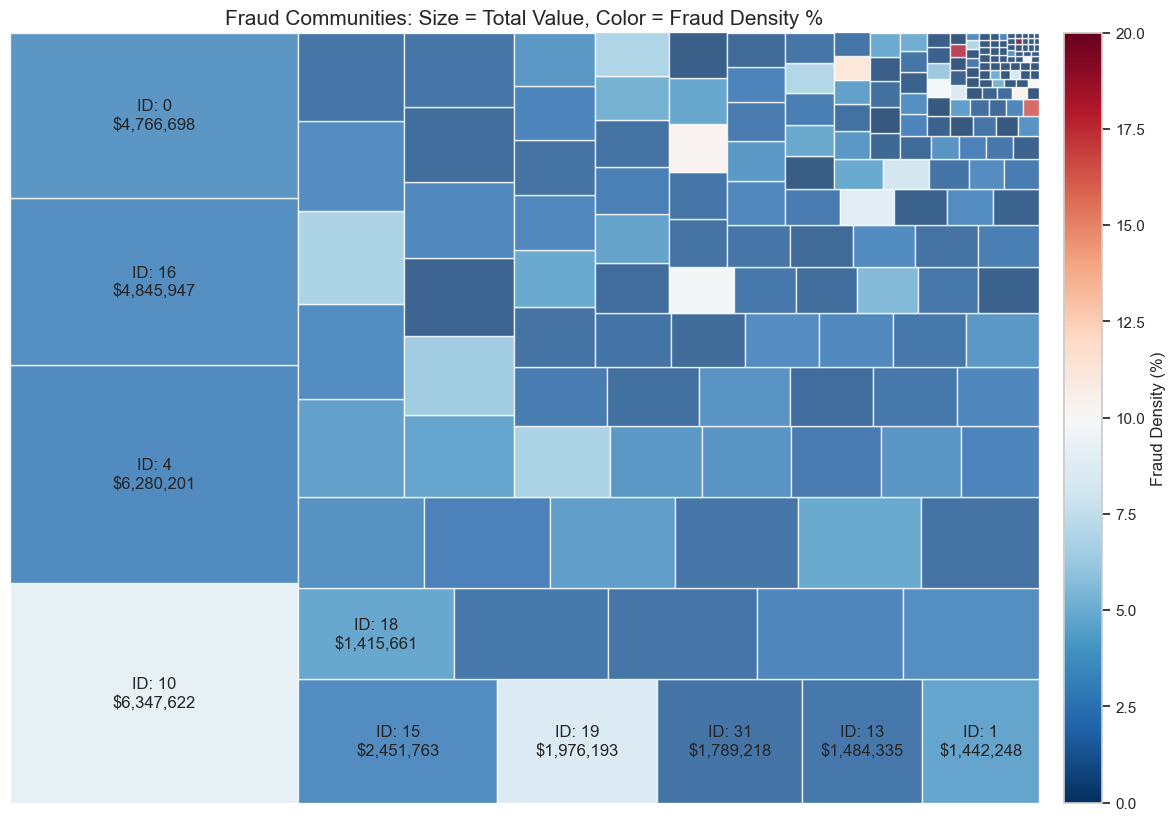

In [20]:
# Query: Get stats for the top 200 largest communities
query = """
MATCH (t:Transaction)
WHERE t.communityId IS NOT NULL
WITH t.communityId AS community, 
     count(t) AS transaction_count, 
     sum(t.isFraud) AS fraud_count, 
     sum(t.amt) AS total_value
// Only return communities with more than 5 transactions to remove noise
WHERE transaction_count > 5 
RETURN community, transaction_count, fraud_count, total_value
ORDER BY total_value DESC
LIMIT 200
"""

analysis.plot_community_treemap(query)

## Fraud Islands

This code block identifies highly suspicious clusters of activity by isolating what are colloquially known as "Fraud Islands." It begins by aggregating transactions based on their community assignments, allowing the system to calculate the exact size and fraud density of every group in the network. By applying specific filters, the query ignores large, noisy clusters and instead targets discrete cells containing between ten and fifty nodes where over sixty percent of the transactions are confirmed fraud. Once these high-risk islands are pinpointed, the query traverses the graph to find the shared infrastructure - such as specific devices, email domains, or devices that serve as the central hub for the fraudulent activity within that community.

The results of this analysis are then transformed into an interactive visual representation to help investigators quickly grasp the scale and structure of the detected rings. The visualization engine scales the physical size of the nodes based on the transaction amount, making high-value targets immediately prominent, while a discrete coloring scheme distinguishes fraudulent nodes in red from legitimate transactions in green. By utilizing a force-directed layout, the visualizer naturally pulls together nodes that share common resources, effectively unmasking the "hidden bridges" used by the fraud ring. This synthesis of graph analytics and visual intelligence allows security teams to move beyond looking at individual transactions and start seeing the underlying criminal architecture.

In [21]:
# Find nodes in small, high-fraud communities

# It starts by grouping transactions by their community ID to calculate the total size and fraud count for each cluster.
# The query filters for suspicious groups that are large enough to indicate coordination but small enough to be discrete cells.
# A density threshold is applied to isolate clusters where more than sixty percent of the activity is confirmed fraud.
# Once these islands are found, the query retrieves the full network path including the hubs and resources they share.
# This helps investigators visualize the common infrastructure like shared devices or IPs used by a fraud ring.
fraud_islands_query = """
MATCH (t:Transaction)
WITH t.communityId AS islandId, count(t) AS sz, sum(t.isFraud) AS f
WHERE sz > 10 AND sz < 50 AND (toFloat(f)/sz) > 0.6
MATCH p = (t2:Transaction {communityId: islandId})-[r]-(hub)
// Ensure we don't return null IDs
WHERE hub.id IS NOT NULL 
RETURN p
"""

fraud_islands_result = analysis.run_query_viz(fraud_islands_query)
print(f"Nodes: {len(fraud_islands_result.nodes)}, Edges: {len(fraud_islands_result.relationships)}")

VG = from_neo4j(fraud_islands_result)
VG.resize_nodes(property="amt", node_radius_min_max=(10, 30))
VG.color_nodes(
    field="caption", # Using the internal labels property
    color_space=ColorSpace.DISCRETE,
    colors={
        "Card": "#1f77b4",        # Blue for Cards
        "Device": "#ff7f0e",      # Orange for Devices
        "Transaction": "#d62728",   # Red for the link (if fraud)
        "Address": "#ff00ff",      # Magenta for Addresses,
        "Email": "#a020f0"        # Purple for Emails
    },
)
VG.color_nodes(
    property="isFraud",
    color_space=ColorSpace.DISCRETE,
    colors={0: "green", 1: "red"},
)
generated_html = VG.render(layout="forcedirected", initial_zoom=0.8, height="800px")

Nodes: 105, Edges: 102


In [22]:
await analysis.capture_graph_to_png(generated_html, "renderings/fraud_island_graph.png")

![Fraud Islands Graph](renderings/fraud_island_graph.png)

## Temporal Analysis: Fraud Velocity

Fraud attacks often happen in bursts. Let us map the transaction volume of top fraud islands over time to visualize their "velocity". High velocity indicates **coordinated attacks**, while low velocity may suggest opportunistic fraud. We use a heatmap to visualize this temporal dimension, where the intensity of color reflects the volume of fraudulent transactions within each community over time. This allows investigators to quickly identify periods of heightened activity, which can be crucial for understanding the tactics and timing of fraud rings.

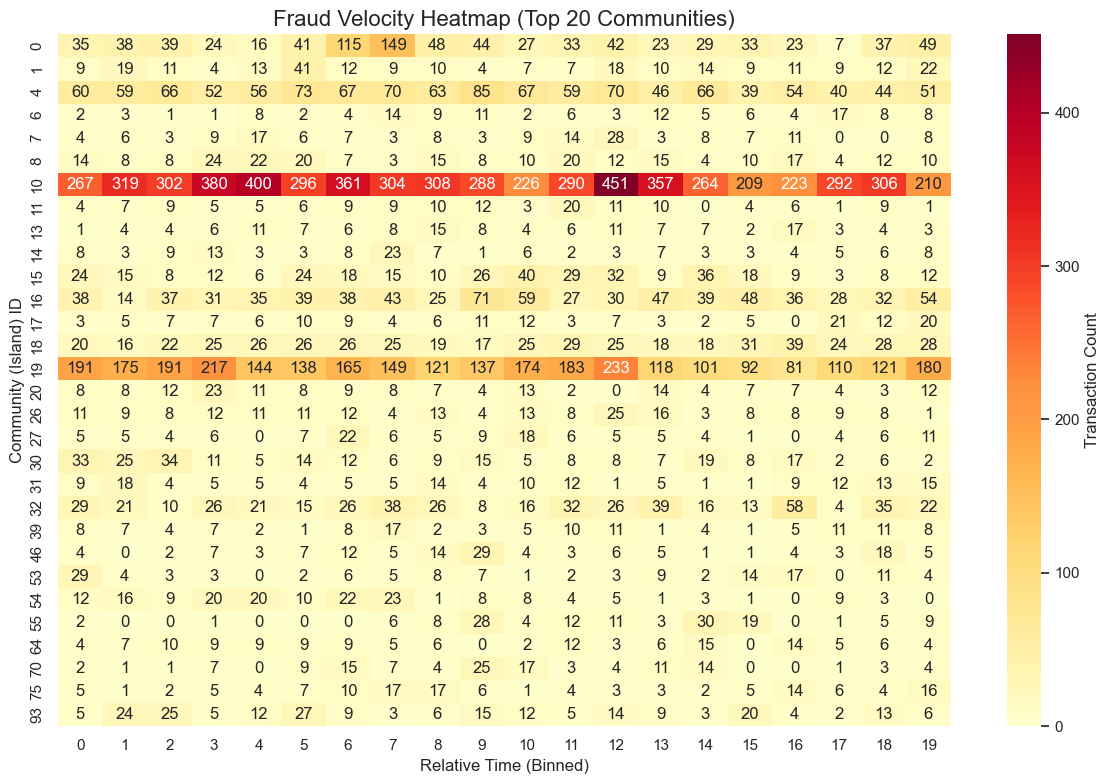

In [23]:
# Query: Get transactions but also calculate island activity 
# so we can filter for the most 'interesting' (readable) ones.
refined_query = """
MATCH (t:Transaction)
WHERE t.communityId IS NOT NULL AND t.isFraud = 1
WITH t.communityId AS islandId, count(t) AS tx_count
WHERE tx_count > 10  // Only look at established rings, not isolated events
RETURN islandId, tx_count
ORDER BY tx_count DESC
LIMIT 30  // Limit to top 30 rings for clear readability
"""

# Get the top islands first
top_islands_data = analysis.run_query(refined_query)
top_islands = [record['islandId'] for record in top_islands_data]

# Get the actual time data for ONLY those top islands
data_query = """
MATCH (t:Transaction)
WHERE t.communityId IN $island_list AND t.isFraud = 1
RETURN t.communityId AS islandId, t.timestamp AS time, t.amt AS amount
"""

df_raw = pd.DataFrame(analysis.run_query(data_query, {"island_list": top_islands}))

BINS = 20

if df_raw.empty:
    print("No data found for the top islands.")
else:
    # Create a Pivot Table for a Heatmap
    # We bin the time into 20 segments to see 'density' rather than individual dots
    df_raw['time_bin'] = pd.cut(df_raw['time'], bins=BINS, labels=False)
    
    # Pivot: Rows = Islands, Columns = Time Bins, Values = Count of Transactions
    heatmap_data = df_raw.pivot_table(
        index='islandId', 
        columns='time_bin', 
        values='amount', 
        aggfunc='count'
    ).fillna(0)

    # Visualization
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data, 
        annot=True,     # Shows the number of transactions in that burst
        fmt=".0f", 
        cmap="YlOrRd",  # Yellow to Red (Red = high velocity)
        cbar_kws={'label': 'Transaction Count'}
    )

    plt.title(f"Fraud Velocity Heatmap (Top {BINS} Communities)", fontsize=16)
    plt.xlabel("Relative Time (Binned)", fontsize=12)
    plt.ylabel("Community (Island) ID", fontsize=12)
    
    plt.tight_layout()
    plt.show()

### Community Deep Dive

Finally, we zoom in on a specific community during a specific activity window to see the exact structure of the attack. In this case, we focus on community `12` during the time bin `7`. This detailed view reveals the interconnected web of transactions, cards, and devices that make up the fraud ring during this period, allowing investigators to trace the flow of illicit funds and identify key nodes within the network.

**Note:** Keep in mind that in real-world scenarios, community IDs and time bins would be dynamically selected based on prior analysis rather than hardcoded values. In the IEEE-CIS-Fraud dataset, time values are anonymized and do not correspond to real-world timestamps. Also observe how the count of fraudulent transactions (red nodes) matches the count in the time bin and community selected (`5` fraudulent transactions).

In [24]:

TARGET_COMMUNITY = 12
TARGET_BIN = 7

# Calculate the time boundaries for the bins
# We need the global min/max to reproduce the same 'cut' used in the heatmap
time_range_query = "MATCH (t:Transaction) RETURN min(t.timestamp) as min_t, max(t.timestamp) as max_t"
time_range = analysis.run_query(time_range_query)[0]
min_t, max_t = time_range['min_t'], time_range['max_t']

# Calculate start and end for the specific bin index
bin_width = (max_t - min_t) / BINS
start_time = min_t + (TARGET_BIN * bin_width)
end_time = min_t + ((TARGET_BIN + 1) * bin_width)

print(f"Visualizing Community {TARGET_COMMUNITY} between {start_time} and {end_time}")

# Query the Subgraph for that specific window
# We fetch the transactions in that community/time and their connections to hubs (Devices, Cards, etc.)
community_bin_query = """
MATCH (t:Transaction)
WHERE t.communityId = $community_id 
  AND t.timestamp >= $start 
  AND t.timestamp < $end
MATCH p = (t)-[r]-(hub)
WHERE NOT hub:Transaction // Focus on the infrastructure linking the transactions
RETURN p
"""

params = {
    "community_id": TARGET_COMMUNITY,
    "start": start_time,
    "end": end_time
}

# Render the visualization
result = analysis.run_query_viz(community_bin_query, params)
print(f"Nodes: {len(result.nodes)}, Edges: {len(result.relationships)}")

VG = from_neo4j(result)
VG.resize_nodes(property="amt", node_radius_min_max=(10, 30))

VG.color_nodes(
    field="caption", # Using the internal labels property
    color_space=ColorSpace.DISCRETE,
    colors={
        "Card": "#1f77b4",        # Blue for Cards
        "Device": "#ff7f0e",      # Orange for Devices
        "Transaction": "#d62728",   # Red for the link (if fraud)
        "Address": "#ff00ff",      # Magenta for Addresses,
        "Email": "#a020f0"        # Purple for Emails
    },
)
# Consistent coloring for fraud status
VG.color_nodes(
    property="isFraud",
    color_space=ColorSpace.DISCRETE,
    colors={0: "green", 1: "red"},
)

# Force-directed layout to see how nodes cluster around shared hubs
generated_html = VG.render(layout="forcedirected", initial_zoom=0.50, height="800px")

Visualizing Community 12 between 5590055.850000001 and 6376292.4
Nodes: 171, Edges: 438


In [25]:
await analysis.capture_graph_to_png(generated_html, "renderings/community_bin_graph.png")

![Community Deep Dive Graph](renderings/community_bin_graph.png)

## Patterns of Fraud

Academic research and industry studies have identified specific **"Graph Motifs"** or typical geometries that distinguish fraud rings from legitimate banking behavior.

In a graph, "geometry" refers to the arrangement of nodes (entities) and edges (relationships). Here are the four most common geometries found in fraud rings:

### The "Star" Topology (Infrastructure Hub)

This is the most common geometry in e-commerce and credit card fraud.

* **Structure:** A single central "Hub" node (usually a **Device ID**, **IP Address**, or **Physical Address**) connected to a high number of "Leaf" nodes (Credit Cards or User Accounts).
* **What it indicates:** One fraudster (the Hub) using an automated script to test hundreds of stolen credentials (the Leaves).
* **Geometry Note:** In legitimate data, the ratio of cards-to-devices is usually 1:1 or 2:1. In fraud rings, this "Star" becomes an outlier with a degree of 20:1 or 100:1.

Let us look at an example of a "Star" topology for `3` detected "star hubs":

In [26]:

# Cypher Query: Identify hubs where over 50% of transactions are fraudulent
# We use toFloat() to ensure decimal division for the ratio calculation
star_percentage_query = """
MATCH (hub)
WHERE hub:Device OR hub:Email
MATCH (hub)--(t:Transaction)
WITH hub, 
     count(t) AS total_connections, 
     sum(t.isFraud) AS fraud_count
// Filter: Must have a minimum number of connections and > 50% fraud rate
WHERE total_connections > 50 
  AND (toFloat(fraud_count) / total_connections) > 0.7
WITH hub, (toFloat(fraud_count) / total_connections) AS fraud_ratio
ORDER BY total_connections DESC, fraud_ratio DESC 
LIMIT 3

// Fetch the star structure for these specific high-ratio hubs
MATCH p = (hub)--(t2:Transaction)
RETURN p
"""

star_pct_result = analysis.run_query_viz(star_percentage_query)
print(f"High-Ratio Stars Detected: {len(star_pct_result.nodes)} nodes across the top high-risk hubs.")

# Visualization
VG = from_neo4j(star_pct_result)

VG.color_nodes(
    field="caption", # Using the internal labels property
    color_space=ColorSpace.DISCRETE,
    colors={
        "Card": "#1f77b4",        # Blue for Cards
        "Device": "#ff7f0e",      # Orange for Devices
        "Transaction": "#d62728",   # Red for the link (if fraud)
        "Address": "#ff00ff",      # Magenta for Addresses,
        "Email": "#a020f0"        # Purple for Emails
    },
)
# Color coding: Red for Fraud, Green for Legitimate
VG.color_nodes(
    property="isFraud",
    color_space=ColorSpace.DISCRETE,
    colors={0: "green", 1: "red"},
)
VG.resize_nodes(property="amt", node_radius_min_max=(10, 30))

generated_html = VG.render(layout="forcedirected", initial_zoom=0.5, height="800px")

High-Ratio Stars Detected: 185 nodes across the top high-risk hubs.


In [27]:
await analysis.capture_graph_to_png(generated_html, "renderings/high_ratio_star_graph.png")

!["Star" Topology Graph](renderings/high_ratio_star_graph.png)


### The "Bipartite" Dense Subgraph

Studies on the **IEEE-CIS dataset** (which we are using) often highlight bipartite structures.

* **Structure:** Two distinct sets of nodes - for example, **Cards** and **Devices** - where every Card in a specific group is connected to every Device in another group, but no nodes within the same group connect to each other.
* **What it indicates:** This is the signature of **Card Polishing** or **Money Laundering**. A group of stolen cards is being "cleaned" by making small purchases across a specific set of "collusive merchants" who are in on the scam.

Here is an example of a "Bipartite" dense subgraph:

In [28]:
# Cypher Query: Find a dense bipartite mesh
# We look for Devices that share multiple Cards, 
# and Cards that have logged in from multiple of those specific Devices.
bipartite_query = """
// Find high-risk devices (shared by multiple fraudulent cards)
MATCH (d:Device)--(t:Transaction)--(c:Card)
WHERE t.isFraud = 1
WITH d, count(DISTINCT c) AS unique_cards
WHERE unique_cards >= 5
WITH collect(d) AS high_risk_devices

// Find the paths connecting these devices through shared cards
// We explicitly name the paths 'p' so the visualizer sees the edges
MATCH p = (d1:Device)-[:ON_DEVICE]-(t:Transaction)-[:USED_CARD]-(c:Card)
WHERE d1 IN high_risk_devices AND t.isFraud = 1
RETURN p
LIMIT 50
"""

bipartite_result = analysis.run_query_viz(bipartite_query)
print(f"Bipartite Subgraph: {len(bipartite_result.nodes)} nodes forming a dense mesh.")

VG = from_neo4j(bipartite_result)

# Color nodes by Label to clearly see the two "sides" of the bipartite graph
VG.color_nodes(
    field="caption", # Using the internal labels property
    color_space=ColorSpace.DISCRETE,
    colors={
        "Card": "#1f77b4",        # Blue for Cards
        "Device": "#ff7f0e",      # Orange for Devices
        "Transaction": "#d62728",   # Red for the link (if fraud)
        "Address": "#ff00ff",      # Magenta for Addresses,
        "Email": "#a020f0"        # Purple for Emails
    },
)

VG.resize_nodes(property="amt", node_radius_min_max=(8, 20))

generated_html = VG.render(layout="forcedirected", initial_zoom=0.75, height="800px")

Bipartite Subgraph: 76 nodes forming a dense mesh.


In [29]:
await analysis.capture_graph_to_png(generated_html, "renderings/bipartite_graph.png")

![Bipartite Topology Graph](renderings/bipartite_graph.png)

### The "Chain" or "Mule" Path

This geometry is typical of **Authorized Push Payment (APP) fraud** and money laundering.

* **Structure:** A long, linear path of nodes: `Source -> Mule 1 -> Mule 2 -> Mule 3 -> Cash out`.
* **What it indicates:** To evade "velocity" triggers, fraudsters move money through a chain of "Money Mules." Each "hop" is designed to break the automated tracking of the bank.
* **Geometry Note:** Fraud rings often exhibit a "diameter" (the longest path between any two nodes) that is much larger than legitimate transaction clusters.

In [30]:
# Cypher Query: Find linear paths (chains) of length 3 to 5
# We look for paths between two different cards that pass through 
# shared infrastructure, where at least one node is confirmed fraud.
mule_path_query = """
MATCH p = (c1:Card)-[:USED_CARD|ON_DEVICE*3..5]-(c2:Card)
WHERE c1 <> c2 
  AND any(n IN nodes(p) WHERE n.isFraud = 1)
RETURN p
LIMIT 2
"""

mule_result = analysis.run_query_viz(mule_path_query)
print(f"Mule Paths Detected: {len(mule_result.nodes)} nodes involved in chain structures.")

VG = from_neo4j(mule_result)

VG.color_nodes(
    field="caption", # Using the internal labels property
    color_space=ColorSpace.DISCRETE,
    colors={
        "Card": "#1f77b4",        # Blue for Cards
        "Device": "#ff7f0e",      # Orange for Devices
        "Transaction": "#d62728",   # Red for the link (if fraud)
        "Address": "#ff00ff",      # Magenta for Addresses,
        "Email": "#a020f0"        # Purple for Emails
    },
)

VG.resize_nodes(property="amt", node_radius_min_max=(8, 20))

generated_html = VG.render(layout="forcedirected", initial_zoom=1.5, height="800px")

Mule Paths Detected: 10 nodes involved in chain structures.


In [31]:
await analysis.capture_graph_to_png(generated_html, "renderings/mule_path_graph.png")

![Mule Path Graph](renderings/mule_path_graph.png)